In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate
from waveletFunctions import wave_signif, wavelet
from palettable.mycarta import Cube1_10

import xrft.xrft as xrft
import subroutines
import vis_eulag

plt.style.use('latex_default.mplstyle')

In [2]:
SETTINGS = vis_eulag.load_settings('settings_local_translb.txt')
folder_path = '/work/bd0620/b309199/translbq3D/'

fileLocations = ['translbq3D_002','translbq3D_014','translbq3D_008','translbq3D_009']
labels=['reference Sim', 'U = const.', 'no valve layer','summer sc.']

# fileLocations = ['translbq3D_001','translbq3D_002','translbq3D_003']
# labels=['PNJ: 60ms$^{-1}$','PNJ: 80ms$^{-1}$ (ref)','PNJ: 100ms$^{-1}$']

# fileLocations = ['translbq3D_002', 'translbq3D_007', 'translbq3D_008']
# labels=['PNJ: 80ms$^{-1}$ (ref)', 'TropJet: 55ms$^{-1}$','no valve layer']
    
ds_list = []
for fileLocation in fileLocations:
    fileLocation = folder_path + fileLocation
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv']
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    # ds.attrs['cp']=24.4/2*ds.rg # consistent with simulation
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    # ds['pprime']=ds['p'] # h12
    ds['pprime']=subroutines.filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 301, y: 72, x: 720)
Coordinates:
    xcr        (y, x) float32 0.0 15.0 30.0 ... 1.076e+04 1.077e+04 1.078e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -2.13e+03 -2.13e+03 ... 2.13e+03 2.13e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/20)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.372e+04 2.372e+04 ... 0.5273 0.5273
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 2.641e+04
    pprime     (t, z, y, x) float32 ...
Attributes: (12/54)
    nt:           4320
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         15000.0
    ...           ...
    grav:         9.80616
    cap:          0.2857142857142857
    capi:         3.5
    capp:         0.7142857142857143
    cappi:        1.4
    compri:       10.659520642663725

xfilter:  600.0
zfilter:  12.0
0
1
2
3


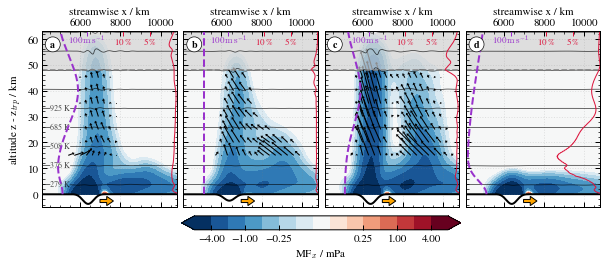

In [18]:
"""Compare MFx and arrows of EF in xz cross sections"""
gskw = {'wspace':0.05}
fig, axes = plt.subplots(1,4,figsize=(10,4),sharey=True, gridspec_kw=gskw)

t=5 # t=3 -> 36h
# XLIM = [3800,10600]
XLIM = [4100,10800]
ZLIM = [-5,63]
xi1 = 273
xi2 = 720

# --- INDEXES FOR VERTICAL AND HORIZONTAL AVERAGE --- #
wind_f = 31.1 # m/s
# nz_avg = int(2*np.pi*wind_f/ds.bv/ds.dz00)+1
nz_avg = 48 # *0.25km -> 12km
# nx_avg = 33
nx_avg = 40
print('xfilter: ', nx_avg*ds.dx00/1000)
print('zfilter: ', nz_avg*ds.dz00/1000)

cmap = plt.get_cmap('RdBu_r')
clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=8)
norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

cmap_th = plt.get_cmap('RdBu_r')
clev_th, clev_l_th = subroutines.get_colormap_bins_and_labels(max_level=32)
norm_th = BoundaryNorm(boundaries=clev_th, ncolors=cmap_th.N, clip=True)

numb_str = ['a','b','c','d','e','f']

for i,ds in enumerate(ds_list):
    print(i)
    ax = axes[i]
    
    y=int(ds.ny/2)
    z = np.linspace(0,ds['zcr'][t,-1,y,0].values,int(ds.nz)) # ds['dx']=200
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,y,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
    vw   = ds['w'][t,:,y,:] * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:])
    mfx  = ds['rh0'][t,:,y,:] * uw # h9=h3*h6
    mfx_ang = ds['rh0'][t,:,y,:] * (uw - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
    mfy  = ds['rh0'][t,:,y,:] * vw
    mfy_ang = ds['rh0'][t,:,y,:] * (vw + f * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz)
    MF_U = mfx * ds['u'][t,:,y,:] + mfy * ds['v'][t,:,y,:] # = -EFz
    MF_U_ang = mfx_ang * ds['ue'][t,:,y,:] + mfy_ang * ds['ve'][t,:,y,:]
    
    efx = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['pprime'][t,:,y,:] # h14, EFx1
    efz = ds['w'][t,:,y,:] * ds['pprime'][t,:,y,:] # h13, EFz1

    # -- TEMPERATURE CALCULATION -- #                             
    thloc = ds['the'][t,:,y,:] + ds['th'][t,:,y,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,:,y,:]*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T_env
    # tte = ds['the'][t,:,y,:]*(ds['ppe'][t,:,y,:]/ds['pref00'])**(2/24.4) # T_env
    tloc = thloc*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte

    ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'][t,:,y,:] #  potential energy density
    # --------- Calculate fluxes -------------------- # 
    
    # --- INTERPOLATE TO AEQUIDISTANT GRID FOR FILTER ----- #
    th   = subroutines.interp_elev_to_z(ds['th'][t,:,y,:],ds.zcr[t,:,y,:],z)
    rho  = subroutines.interp_elev_to_z(ds['rh0'][t,:,y,:],ds.zcr[t,:,y,:],z)
    ue    = subroutines.interp_elev_to_z(ds['ue'][t,:,y,:],ds.zcr[t,:,y,:],z)
    u    = subroutines.interp_elev_to_z(ds['u'][t,:,y,:],ds.zcr[t,:,y,:],z)
    mfx  = subroutines.interp_elev_to_z(mfx,ds.zcr[t,:,y,:],z)
    mfx_ang  = subroutines.interp_elev_to_z(mfx_ang,ds.zcr[t,:,y,:],z)
    mfy_ang  = subroutines.interp_elev_to_z(mfy_ang,ds.zcr[t,:,y,:],z)
    mfy  = subroutines.interp_elev_to_z(mfy,ds.zcr[t,:,y,:],z)
    efx  = subroutines.interp_elev_to_z(efx,ds.zcr[t,:,y,:],z)
    efz  = subroutines.interp_elev_to_z(efz,ds.zcr[t,:,y,:],z)
    ep   = subroutines.interp_elev_to_z(ep,ds.zcr[t,:,y,:],z)
    MF_U = subroutines.interp_elev_to_z(MF_U,ds.zcr[t,:,y,:],z)
    MF_U_ang = subroutines.interp_elev_to_z(MF_U_ang,ds.zcr[t,:,y,:],z)
    
    # --- FFT OR RUNNING MEAN FILTER ------ #
    mm = 1
    # --- 2D filter --- # 
    # uw=filter_2D(uw,nx_avg,nz_avg,mode=mm)
    # ep=filter_2D(ep,nx_avg,nz_avg,mode=mm)
    
    # --- 1D filter --- #
    # mfx = subroutines.filter_1Dz(mfx,nz_avg,mode=mm)
    mfx = subroutines.filter_2D(mfx,nx_avg,nz_avg,mode=mm)
    # mfx_ang = subroutines.filter_1Dz(mfx_ang,nz_avg,mode=mm)
    mfx_ang = subroutines.filter_2D(mfx_ang,nx_avg,nz_avg,mode=mm)
    mfy_ang = subroutines.filter_2D(mfy_ang,nx_avg,nz_avg,mode=mm)
    mfy = subroutines.filter_1Dz(mfy,nz_avg,mode=mm)
    ep  = subroutines.filter_1Dz(ep,nz_avg,mode=mm)
    # efx = subroutines.filter_1Dz(efx,nz_avg,mode=mm)
    # efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm)
    efx = subroutines.filter_2D(efx,nx_avg,nz_avg,mode=mm)
    efz = subroutines.filter_2D(efz,nx_avg,nz_avg,mode=mm)
    # MF_U = subroutines.filter_1Dz(MF_U,nz_avg,mode=mm)
    # MF_U_ang = subroutines.filter_1Dz(MF_U_ang,nz_avg,mode=mm)
    
    # - Calc fluxes after interpolations and averaging/filtering - #
    # MF_U_ang = mfx_ang*ue
    MF_ang = np.sqrt(mfx_ang**2+mfy_ang**2)
    # -- VISUALIZATION -- #
    lw = 2
    contf = ax.contourf(ds.xcr[y], z, mfx*1000, levels=clev, cmap=cmap, norm=norm, extend='both')
    # contf = ax.contourf(ds.xcr[y], z, mfx_ang*1000, levels=clev, cmap=cmap, norm=norm, extend='both')
    # contf = ax.contourf(ds.xcr[y], z, -MF_ang*1000, levels=clev, cmap=cmap, norm=norm, extend='both')
    # contf = ax.pcolormesh(ds.xcr[y], z, mfx*1000, cmap=cmap, norm=norm)
    
    # efx = np.where(abs(efx)>0,0,0)
    efz = np.where(abs(efz)>0.003,efz,np.nan)
    
    efmax = np.max(np.sqrt(efx**2+efz**2))
    efx = efx/efmax.values
    efz = efz/efmax.values
    
    nn = 20
    zbot = 60
    if i!=3:
        Q = ax.quiver(ds.xcr[y][::nn],z[zbot:ds.nz-2*zbot:nn], efx[zbot:ds.nz-2*zbot:nn, ::nn], efz[zbot:ds.nz-2*zbot:nn,::nn], 
                      angles='xy', width=0.008, scale=1/50, headwidth=3,headlength=2,headaxislength=2)
    # qk = ax3.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
    #                coordinates='figure')

    thlev=np.exp(5+0.03*np.arange(1,120,10))
    y = int(ds.ny/2)
    isentropes = ax.contour(ds.xcr.expand_dims({'z':ds.z},axis=0)[:,y,:], ds.zcr[t,:,y,:], ds['the'][t,:,y,:]+ds['th'][t,:,y,:], colors='k', alpha=0.7, levels=thlev)
    ax.plot(ds.xcr[y], 5*ds.zcr[t,0,y,:], lw=2, color='black')
    # ax.set_title(time_label,pad=10)
    
    ax.set_xlabel('streamwise x / km')
    ax.set_xlim(XLIM)
    
    # - SPONGE LAYER - #
    lw_sponge = 1.5
    hsponge = 48
    c3 = 'lightgrey'
    htop = 73
    alpha_sponge = 0.67
    ax.axhline(y=hsponge, lw=lw_sponge,ls='--',color='grey')
    ax.fill_between(ax.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
    # sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
    # ax.text(0.05, 0.8, sponge_label, transform=ax0.transAxes, color='grey')
    
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True)
    
    if i==0:
        ax.set_ylim(ZLIM)
        ax.set_ylabel(r'altitude z - z$_{trp}$ / km')
        fig.canvas.draw()
        height_tick = ax.get_yticks()
        height_tick_labels = ax.get_yticklabels()
        height_tick_labels[0] = r"0 (z$_{trp}$)"
        ax.set_yticks(height_tick)
        ax.set_yticklabels(height_tick_labels)
        ax.set_ylim(ZLIM)
        
        th_z_pos = np.linspace(5,36,5)
        th_label = []
        for pos in th_z_pos:
            th_label.append((5000,pos))
        ax.clabel(isentropes, fmt='%1.0f K', inline_spacing=0, inline=True, fontsize=8, manual=th_label)
    
    ax_wind = ax.twiny()
    ax_mwind = ax.twiny()
    x=0
    c4='darkorchid'
    c5='crimson'
    
    ax_wind.plot(ds['ue'][t,:,y,x], ds.zcr[t,:,y,x], lw=2, ls='--', color=c4, label='$u_e$')
    # ax_wind.tick_params(axis='x', which='both', top=False)
    ax_wind.set_xlim([0,300])
    # ax_wind.xaxis.set_minor_locator(AutoMinorLocator())
    wind_xticks = ax_wind.get_xticks()
    ax_wind.set_xticks([wind_xticks[1]], labels=['100$\, \mathrm{m} \, \mathrm{s}^{-1}$'], fontsize=9, visible=True)
    ax_wind.tick_params(axis="x",direction="in", pad=-15, colors=c4, labelbottom=False)
    ax_wind.xaxis.label.set_color(c4)
    
    udiss = (u[:,xi1:xi2].mean(axis=1) - ue[:,0]) / ue[:,0]
    ax_mwind.plot(udiss, ds.zcr[t,:,y,x], lw=1, color=c5)
    ax_mwind.set_xlim(-0.25,0)
    # mwind_xticks = ax_mwind.get_xticks()
    # print(mwind_xticks)
    ax_mwind.set_xticks([-0.1,-0.05], labels=['10$\,$%', '5$\,$%'], fontsize=9, visible=True)
    ax_mwind.tick_params(axis="x",direction="in", pad=-15, colors=c5, labeltop=True, labelbottom=False)
    
    ax.tick_params(axis="x", which='both', labeltop=True, labelbottom=False, top=True)
    ax.xaxis.set_label_position("top")
    
    calc_wavelet = False
    if calc_wavelet:
        cmap_wave = Cube1_10.mpl_colormap
        # clev_wave = [300,400,500,600,700,800,900,1000,1100,1200]
        clev_wave = np.linspace(15.5,17,8)
        norm_wave = BoundaryNorm(boundaries=clev_wave,ncolors=cmap_wave.N,clip=True)
        
        mother = 'MORLET'
        lag1 = 0.72  # lag-1 autocorrelation for red noise background
        sig_lev = 1

        # -- lambda z -- #
        data = ds['th'][t,:,y,:]
        variance = np.std(data, ddof=1) ** 2
        lambdaz = np.zeros(np.shape(data))
        
        n = ds.nz
        dz = ds.dz00/1000 # km
        # pad = 1  # pad the time series with zeroes (recommended)
        dj = 0.0625  # this will do 4 sub-octaves per octave
        s0 = 2 * dz  # this says start at a scale of 6 months
        j1 = 5 / dj  # this says do 7 powers-of-two with dj sub-octaves each

        for xi in range(0,ds.nx):
            wave, period, scale, coi = wavelet(data[:,xi], dz, dj=dj, s0=s0, J1=j1, mother=mother)
            power = (np.abs(wave)) ** 2  # / variance # wavelet power spectrum normalized by variance

            # - Significance levels - #
            signif = wave_signif(([variance]), dt=dx, sigtest=0, scale=scale, lag1=lag1, mother=mother)
            # expand signif --> (J+1)x(N) array
            sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
            sig95 = power / sig95  # where ratio > 1, power is significant

            # jvec holds indices of maximum power for each x-location
            # indices refer to certain wavelengths
            jvec = np.argmax(power,axis=0)
            xvec = np.arange(0,len(jvec),1)
            lambdaz[:,xi] = np.where(sig95[jvec,xvec] > sig_lev, period[jvec], np.nan)
        
        # lambdax = np.where(lambdax<800,lambdax,np.nan)
        # contf = ax.contourf(ds.xcr[y],ds.zcr[t,:,y,0],lambdaz,cmap=cmap_wave,norm=norm_wave,levels=clev_wave,extend='both')
        cont = ax.contour(ds.xcr[y],ds.zcr[t,:,y,0],lambdaz,levels=[15.5,16,16.5])
        print(np.nanmax(lambdaz))
    
    ax.arrow(0.43, 0.035, 0.05, 0, width = 0.0175, head_length=0.05, transform=ax.transAxes,  facecolor='orange', edgecolor='black')
    ax_wind.text(0.06, 0.91, numb_str[i], transform=ax.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    
clev_l = [-4,-1,-0.25,0.25,1,4]
cbar = fig.colorbar(contf, ax=axes, location='bottom', pad=0.04, shrink=0.5, ticks=clev_l)
cbar.set_label(r"MF$_x$ / mPa")

# --- Limits and Sci format --- #
# ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
# ax0.set_xlim([-0.8,0.07]) # MFx

# filter_label = '$\lambda_z$ (filter): ' + str(int(nz_avg*ds.dz00/1000)) + 'km'
# ax.text(0.5, 0.9, filter_label, transform=ax.transAxes)

# --- Save figure --- #
fig_title = 'Q3D-MFx-towers.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
### Comparison of 3D simulations in meridional cross-section with perturbations and EF plus MF in second column
### Consider three simulations with PNJ positions, tilted and stronger PNJ??

In [9]:
# -- lambda x -- #
        data = ds['th'][t,:,y,:]
        variance = np.std(data, ddof=1) ** 2
        lambdax = np.zeros(np.shape(data))
        
        n = ds.nx
        dx = ds.dx00/1000 # km
        # pad = 1  # pad the time series with zeroes (recommended)
        dj = 0.0625  # this will do 4 sub-octaves per octave
        s0 = 2 * dx  # this says start at a scale of 6 months
        j1 = 5 / dj  # this says do 7 powers-of-two with dj sub-octaves each

        for zi in range(0,ds.nz):
            wave, period, scale, coi = wavelet(data[zi,:], dx, dj=dj, s0=s0, J1=j1, mother=mother)
            power = (np.abs(wave)) ** 2  # / variance # wavelet power spectrum normalized by variance

            # - Significance levels - #
            signif = wave_signif(([variance]), dt=dx, sigtest=0, scale=scale, lag1=lag1, mother=mother)
            # expand signif --> (J+1)x(N) array
            sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
            sig95 = power / sig95  # where ratio > 1, power is significant

            # jvec holds indices of maximum power for each x-location
            # indices refer to certain wavelengths
            jvec = np.argmax(power,axis=0)
            xvec = np.arange(0,len(jvec),1)
            lambdax[zi,:] = np.where(sig95[jvec,xvec] > sig_lev, period[jvec], np.nan)
        
        
        # lambdax = np.where(lambdax<800,lambdax,np.nan)
        cont_lambdax = ax.contour(ds.xcr[y], ds.zcr[t,:,y,0], lambdax, levels=[400,500,600,700], colors='k')
        print(np.nanmin(lambdax))

10800.0

In [42]:
ds.zcr

<xarray.DataArray 'zcr' (t: 7, z: 301, y: 72, x: 720)>
array([[[[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         ...,
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]],

        [[ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
         [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
         [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
         ...,
         [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
         [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25],
         [ 0.25,  0.25,  0.25, ...,  0.25,  0.25,  0.25]],

        [[ 0.5 ,  0.5 ,  0.5 , ...,  0.5 ,  0.5 ,  0.5 ],
         [ 0.5 ,  0.5 ,  0.5 , ...,  0.5 ,  0.5 ,  0.5 ],
         [ 0.5 ,  0.5 ,  0.5 , ...,  0.5 ,  0.5 ,  0.5 ],
         ...,
...
         ...,
         [74.5 , 74.5 , 74.5 , ..., 74.5 , 74.5 , 74.5 ],
         [74.5 , 74.5 , 74.5 , ..., 74.5 , 74.5 , 74.5 ],
         [74.5 , 74.5 , 74.5 , ..., 74.5 , 74.5 , 74.5 ]],

        [[74.75, 74.75, 74.75, ..., 74.75, 74.75, 74.75],
         [74.75, 74.75, 74.75, ..., 74.75, 74.75, 74.75],
         [74.75, 74.75, 74.75, ..., 74.75, 74.75, 74.75],
         ...,
         [74.75, 74.75, 74.75, ..., 74.75, 74.75, 74.75],
         [74.75, 74.75, 74.75, ..., 74.75, 74.75, 74.75],
         [74.75, 74.75, 74.75, ..., 74.75, 74.75, 74.75]],

        [[75.  , 75.  , 75.  , ..., 75.  , 75.  , 75.  ],
         [75.  , 75.  , 75.  , ..., 75.  , 75.  , 75.  ],
         [75.  , 75.  , 75.  , ..., 75.  , 75.  , 75.  ],
         ...,
         [75.  , 75.  , 75.  , ..., 75.  , 75.  , 75.  ],
         [75.  , 75.  , 75.  , ..., 75.  , 75.  , 75.  ],
         [75.  , 75.  , 75.  , ..., 75.  , 75.  , 75.  ]]]], dtype=float32)
Coordinates:
    xcr      (y, x) float32 0.0 15.0 30.0 45.0 ... 1.076e+04 1.077e+04 1.078e+04
    zcr      (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr      (y, x) float32 -2.13e+03 -2.13e+03 -2.13e+03 ... 2.13e+03 2.13e+03
    zs       (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh       (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi       (y, x) float32 ...
Dimensions without coordinates: t, z, y, x